In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import matplotlib.image as mpimg
import glob2
import math
from moviepy.editor import VideoFileClip

pygame 1.9.4
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
print(cv2.__version__)

3.4.1


In [3]:
def blur_image(image):
    return(cv2.blur(image,(5,5)))


In [4]:
def grayscale_image(image):
    return cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

In [5]:
def gaussianblur_image(image):
    return(cv2.GaussianBlur(image,(5,5),0))


In [6]:
def canny_image(image,low_threshold, high_threshold):
    return(cv2.Canny(image,low_threshold, high_threshold))



In [7]:
def display_window(img):
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


In [8]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:  # if it is not gray-scale
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [9]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=1):    
    left_lines = []
    right_lines = []
    top_y = 1e6

    for line in lines:
        # no lane should be verticle view from the car
        for x1, y1, x2, y2 in line:
            if x1 != x2:
                slope = (y2 - y1) / (x2 - x1)
                if slope > 0:
                    left_lines.append([x1, y1, x2, y2])
                    # cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                else:
                    right_lines.append([x1, y1, x2, y2])
                    # cv2.line(img, (x1, y1), (x2, y2), [0,0,255], thickness)
            if top_y > y1:
                top_y = y1
            if top_y > y2:
                top_y = y2

    # get the average position of each line
    if len(left_lines) > 0:
        left_line = [0, 0, 0, 0]
        for line in left_lines:
            assert (len(line) == 4)
            for i in range(4):
                left_line[i] += (line[i] / len(left_lines))
        slope = (left_line[3] - left_line[1]) / (left_line[2] - left_line[0])
        top_x = left_line[0] + (top_y - left_line[1]) / slope
        bottom_x = left_line[0] + (img.shape[0] - left_line[1]) / slope
        # cv2.line(img, (left_line[0], left_line[1]), (left_line[2], left_line[3]), color, thickness * 10)
        cv2.line(img, (int(bottom_x), img.shape[0]), (int(top_x), int(top_y)), color, thickness * 10)

    # get the average position of each line
    if len(right_lines) > 0:
        right_line = [0, 0, 0, 0]
        for line in right_lines:
            assert (len(line) == 4)
            for i in range(4):
                right_line[i] += (line[i] / len(right_lines))
        slope = (right_line[3] - right_line[1]) / (right_line[2] - right_line[0])
        top_x = right_line[0] + (top_y - right_line[1]) / slope
        bottom_x = right_line[0] + (img.shape[0] - right_line[1]) / slope
        # cv2.line(img, (right_line[0], right_line[1]), (right_line[2], right_line[3]), [0,0,255], thickness * 10)
        cv2.line(img, (int(bottom_x), img.shape[0]), (int(top_x), int(top_y)), color, thickness * 10)

In [10]:
# def draw_lines(image,lines,color=[255,0,0],thickness=1):
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             if x1 != x2:
#                 slope = (y2-y1)/(x2-x1)
#     x = x1-(y1/slope)
#     cv2.line(image,(int(x),0),(int(x1),int(y1)),color, thickness * 10)
                

In [11]:
def hough_image(image,rho,theta,threshold, min_line_len,min_line_gap):
    lines = cv2.HoughLinesP(image,rho,theta,threshold, minLineLength=min_line_len,maxLineGap=min_line_gap)
    line_img = np.zeros((*image.shape,3), dtype=np.uint8)
    draw_lines(line_img, lines)
#     if lines is not None:
#         for i in range(0, len(lines)):
#             l = lines[i][0]
#             cv2.line(line_img, (l[0], l[1]), (l[2], l[3]), (120,0,255), 3, cv2.LINE_8)
    draw_lines(line_img, lines)
    return line_img

In [12]:
def weighted_image(rgb_line_image,image,a=0.8,b=1,l=0):
    return cv2.addWeighted(rgb_line_image,a,image,b,l)

In [13]:
def draw_lane_line(image):
    imshape = image.shape
    f = plt.figure(figsize=(100,35))
    ax1, ax2, ax3, ax4,ax5,ax6 = f.subplots(6, 1, sharex='col', sharey='row')
    gray_scale_image = grayscale_image(image)
    ax1.imshow(gray_scale_image)
    ax1.set_title('gray_scale_image')
    gaussian_blur_image = gaussianblur_image(gray_scale_image)
    ax2.imshow(gaussian_blur_image)
    ax2.set_title('gaussian_blur_image')
    edge_line_image = canny_image(gaussian_blur_image,50,100)
    ax3.imshow(edge_line_image)
    ax3.set_title('edge_line_image')
    vertices = np.array([[(0, imshape[0]), (465, 320), (475, 320), (imshape[1], imshape[0])]], dtype=np.int32)
    edges_image_with_mask = region_of_interest(edge_line_image, vertices)
    ax4.imshow(edges_image_with_mask)
    ax4.set_title('edges_image_with_mask')
    #print("edges_image_with_mask:",edges_image_with_mask.shape)
    bw_edges_image_with_mask = cv2.cvtColor(edges_image_with_mask, cv2.COLOR_GRAY2BGR)
    #print("bw_edges_image_with_mask:",bw_edges_image_with_mask.shape)
    ax5.imshow(bw_edges_image_with_mask)
    ax5.set_title('bw_edges_image_with_mask')
    rho = 2 
    theta = np.pi/180 
    threshold = 45    
    min_line_len = 40
    max_line_gap = 100 
    lines_image = hough_image(edges_image_with_mask, rho, theta,threshold, min_line_len, max_line_gap)
    ax6.imshow(lines_image)
    ax6.set_title('lines_image')
    #hough_rgb_image = cv2.cvtColor(lines_image, cv2.COLOR_GRAY2BGR)
    final_image = weighted_image(lines_image, image)
    return final_image

In [14]:
def read_image(image_path):
    """Reads and returns image."""
    return mpimg.imread(image_path)

(540, 960, 3)


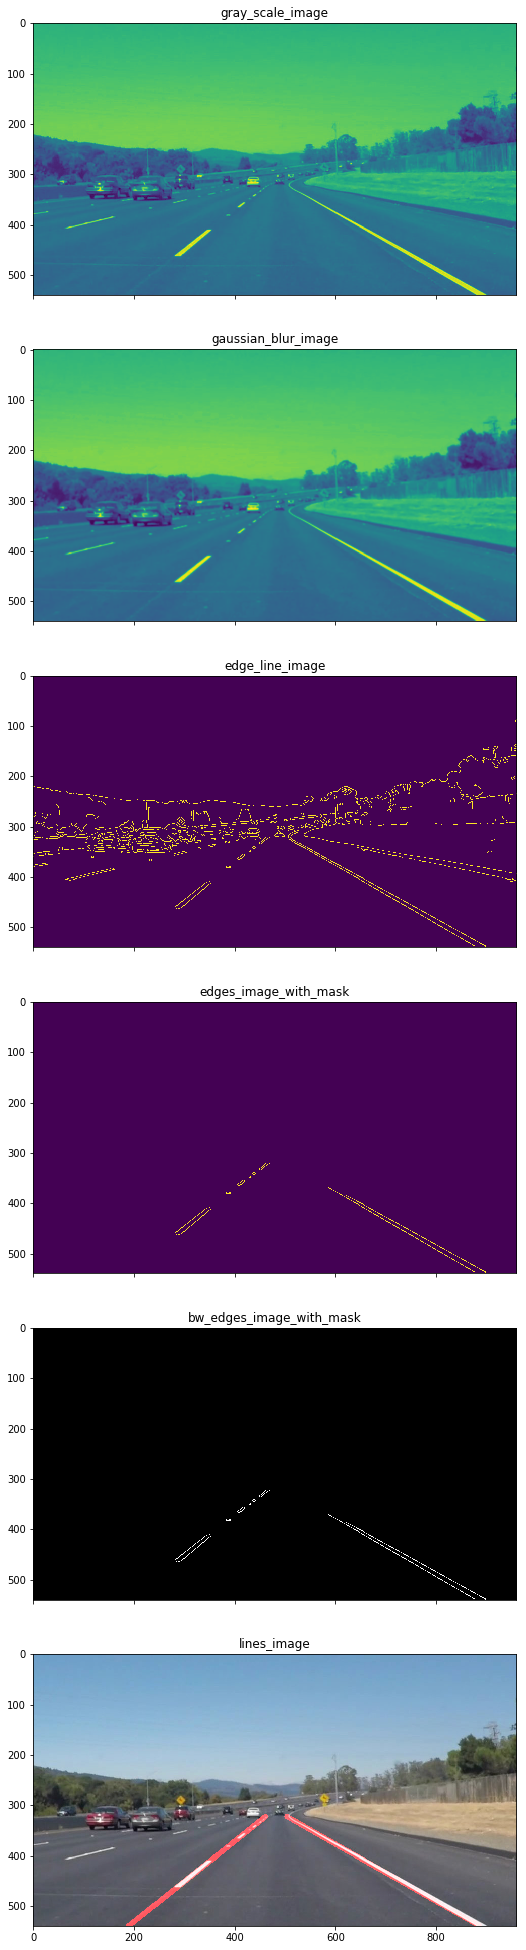

In [15]:
import os
test_images = [read_image('test_images/' + i) for i in os.listdir('test_images/')]
print(test_images[0].shape)
plt.imshow(draw_lane_line(test_images[0]))


(540, 960, 3)


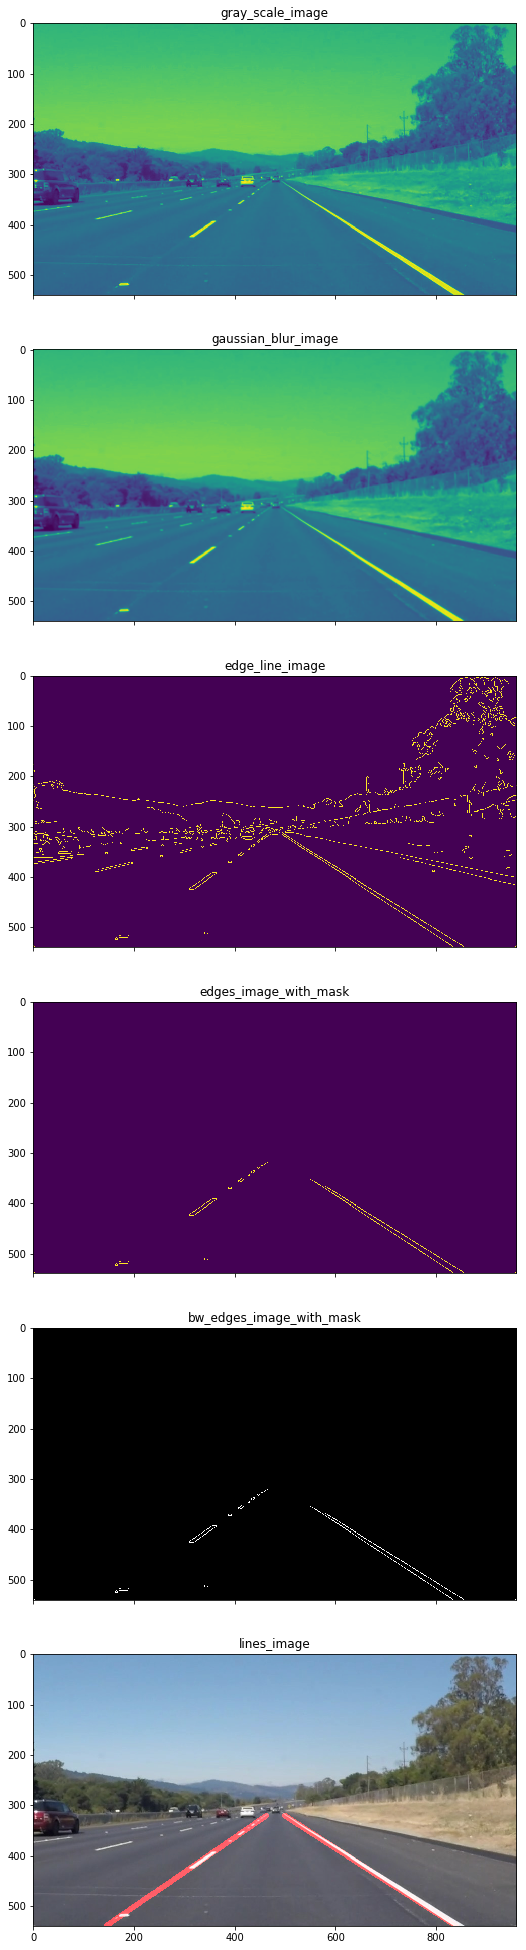

In [16]:
print(test_images[1].shape)
plt.imshow(draw_lane_line(test_images[1]))


(540, 960, 3)


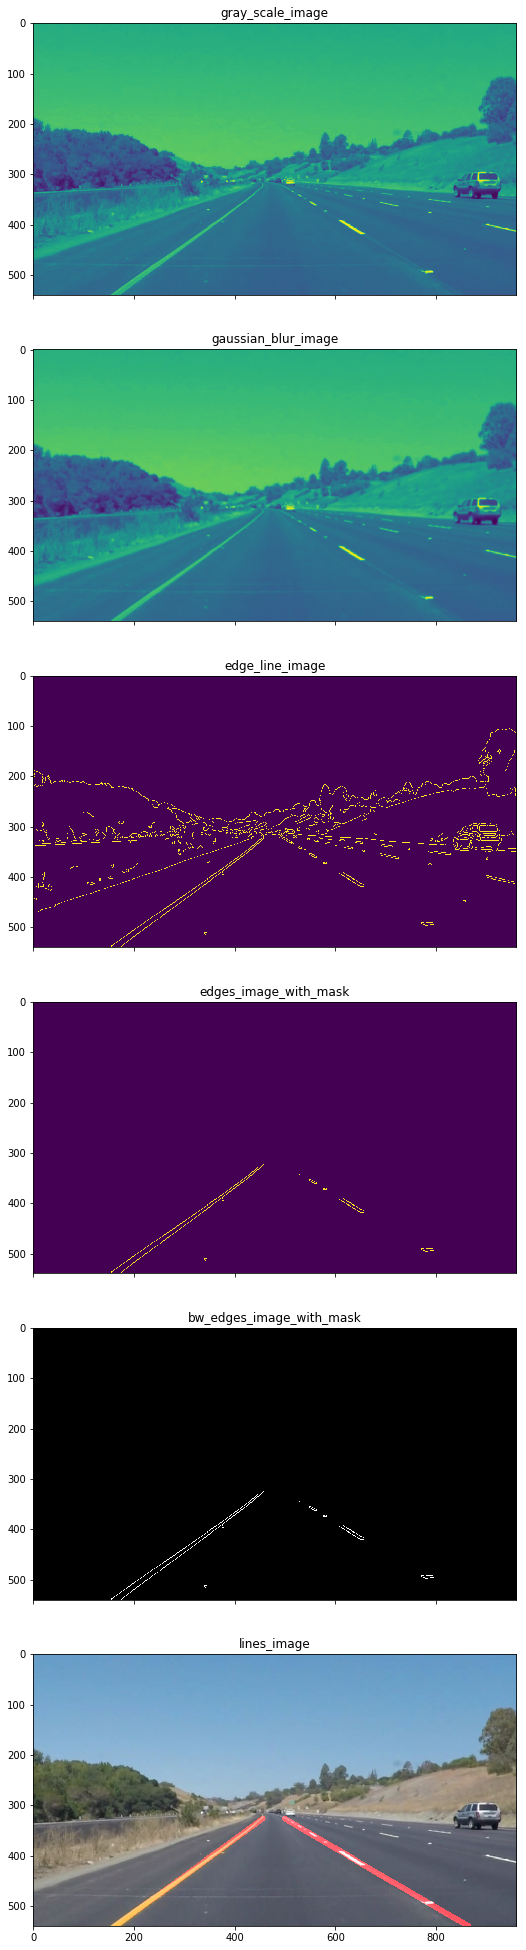

In [17]:
print(test_images[2].shape)
plt.imshow(draw_lane_line(test_images[2]))


(540, 960, 3)


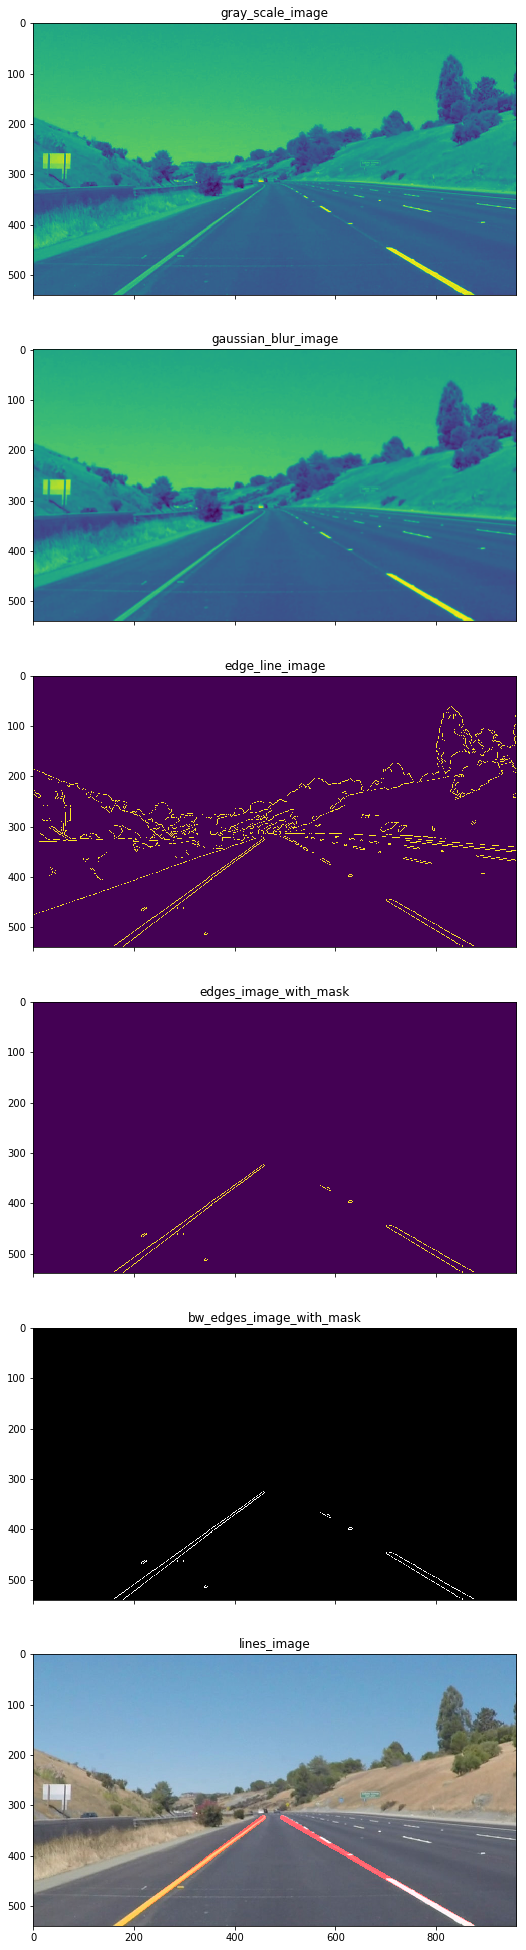

In [18]:
print(test_images[3].shape)
plt.imshow(draw_lane_line(test_images[3]))

(540, 960, 3)


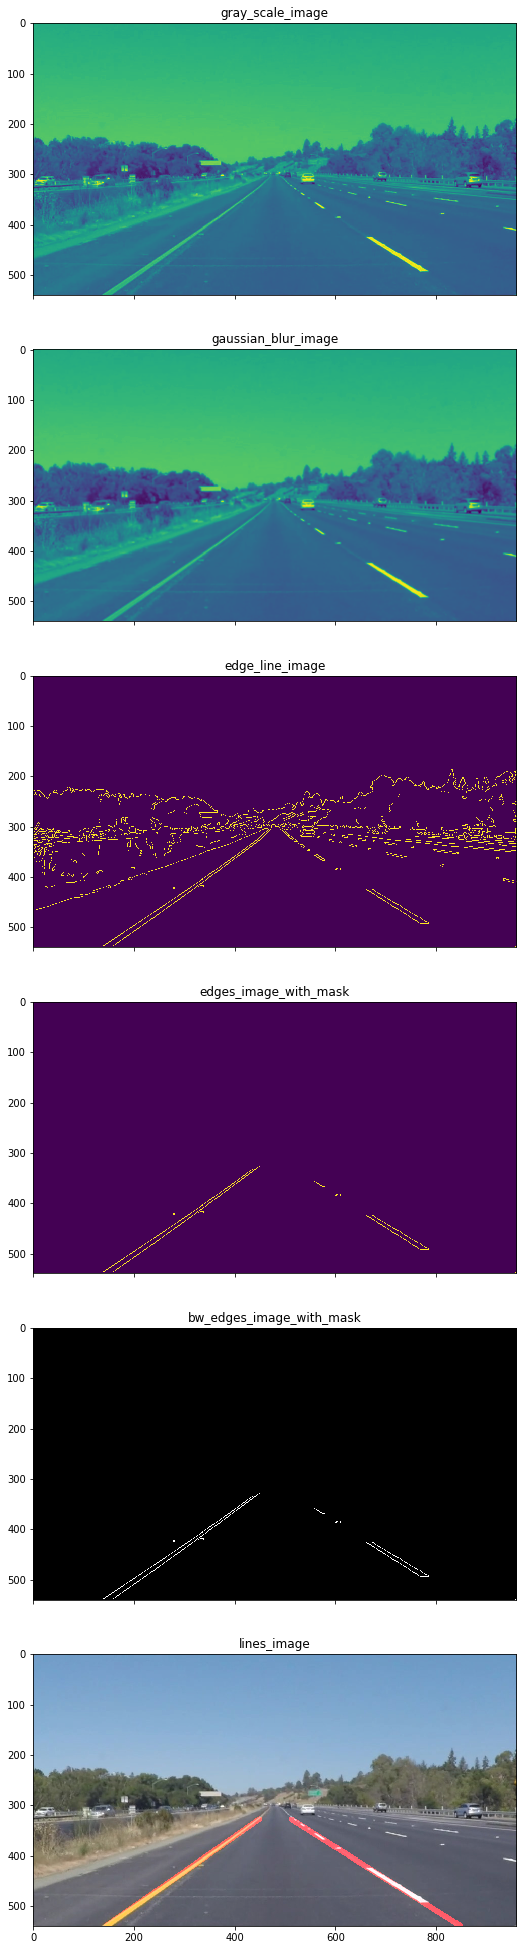

In [19]:
print(test_images[4].shape)
plt.imshow(draw_lane_line(test_images[4]))

(540, 960, 3)


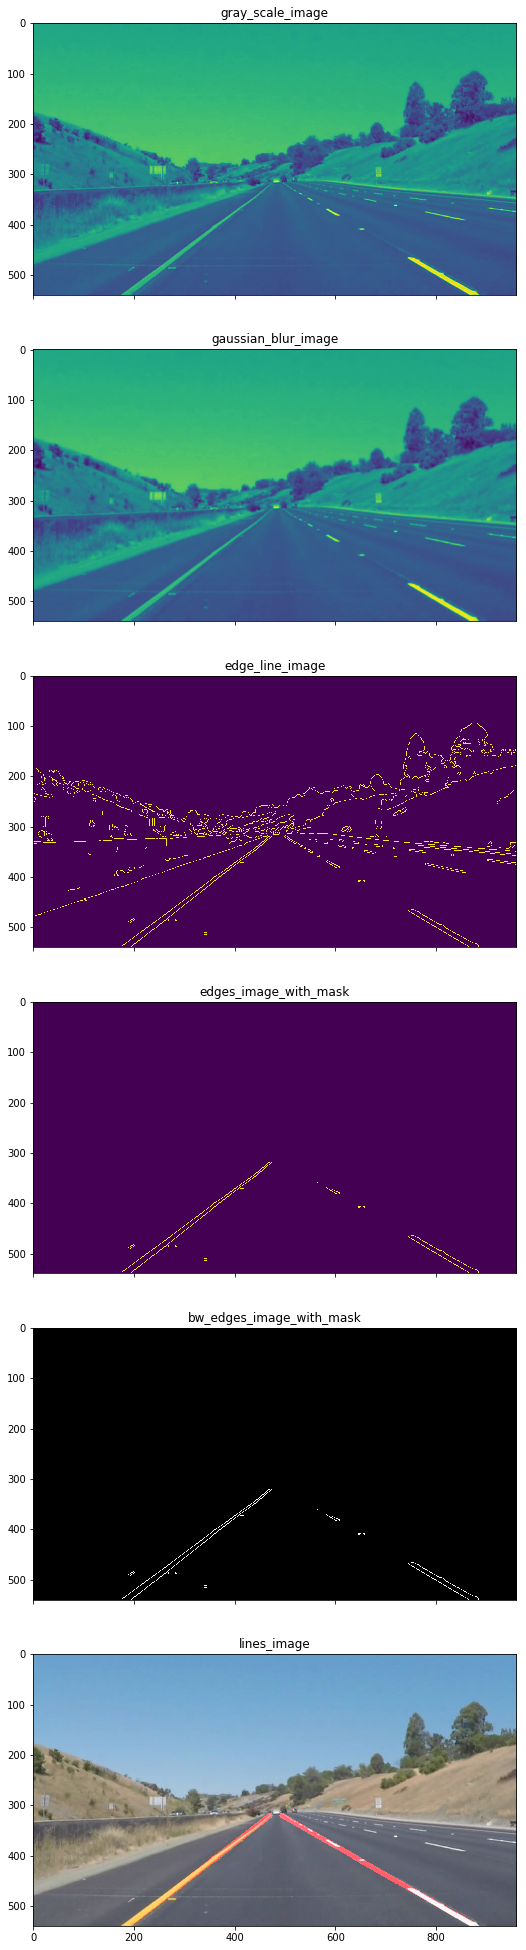

In [20]:
print(test_images[5].shape)
plt.imshow(draw_lane_line(test_images[5]))

In [21]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lane_line(image)
    print(result.shape)
    return result

In [22]:
# from moviepy.editor import VideoFileClip
# white_output = 'result_straight.mp4'
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
# white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# white_clip.write_videofile(white_output, audio=False)